In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import pickle
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../../src/").iterdir()
    if folder.is_dir()
]

# from fitting_utils import create_violation_interaction_pairs
# from experiment_sigma_sweep import ExperimentSigmaSweep
# from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import *


sns.set_context("talk")
%load_ext autoreload
%autoreload 2

For plot of previous choice regressor demo see 2023_-_11_07_dev_multi_tau.ipynb, not i had to set manually drop to false in the DesignMatrixGenerator to create it. For the plot of performance post-vioaltion see 2023_10_24_jp_meeting.ipynb 

In [3]:
file_path = "../../data/results/"
experiment_fname = "2023_11_08_tau_sweep_prev_choice.pkl"

In [22]:
# open experiment pkls
with open(file_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)

# init model vis
mv = ModelVisualizerTauSweep(experiment)

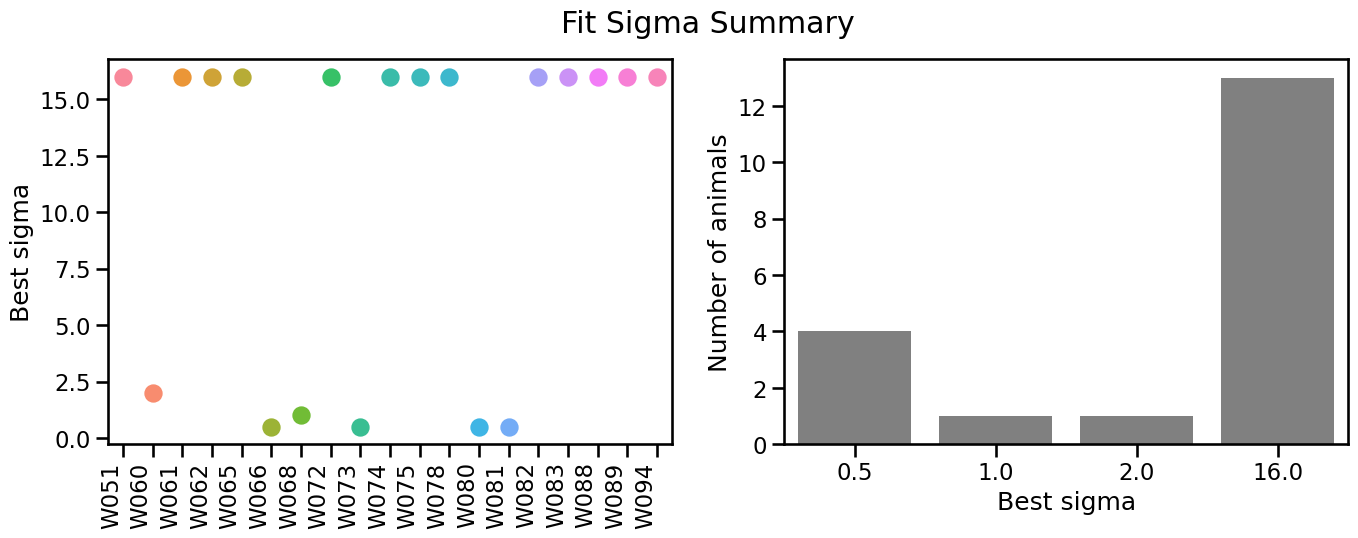

In [7]:
mv.plot_sigma_summary()

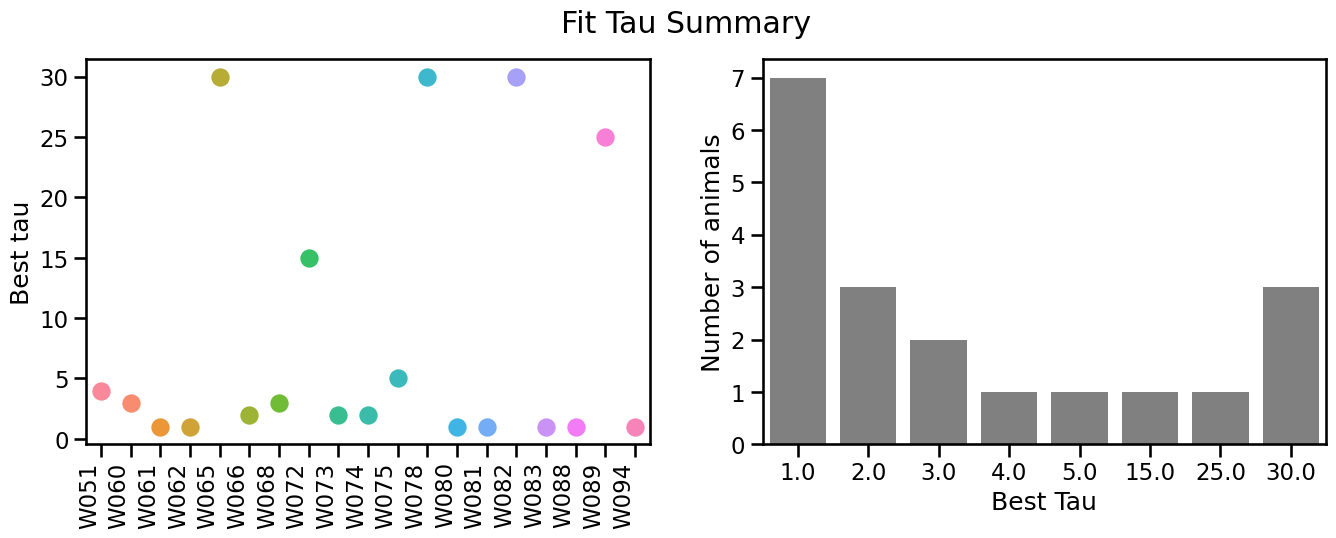

In [8]:
mv.plot_tau_summary()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (0,) and arg 1 with shape (2,).

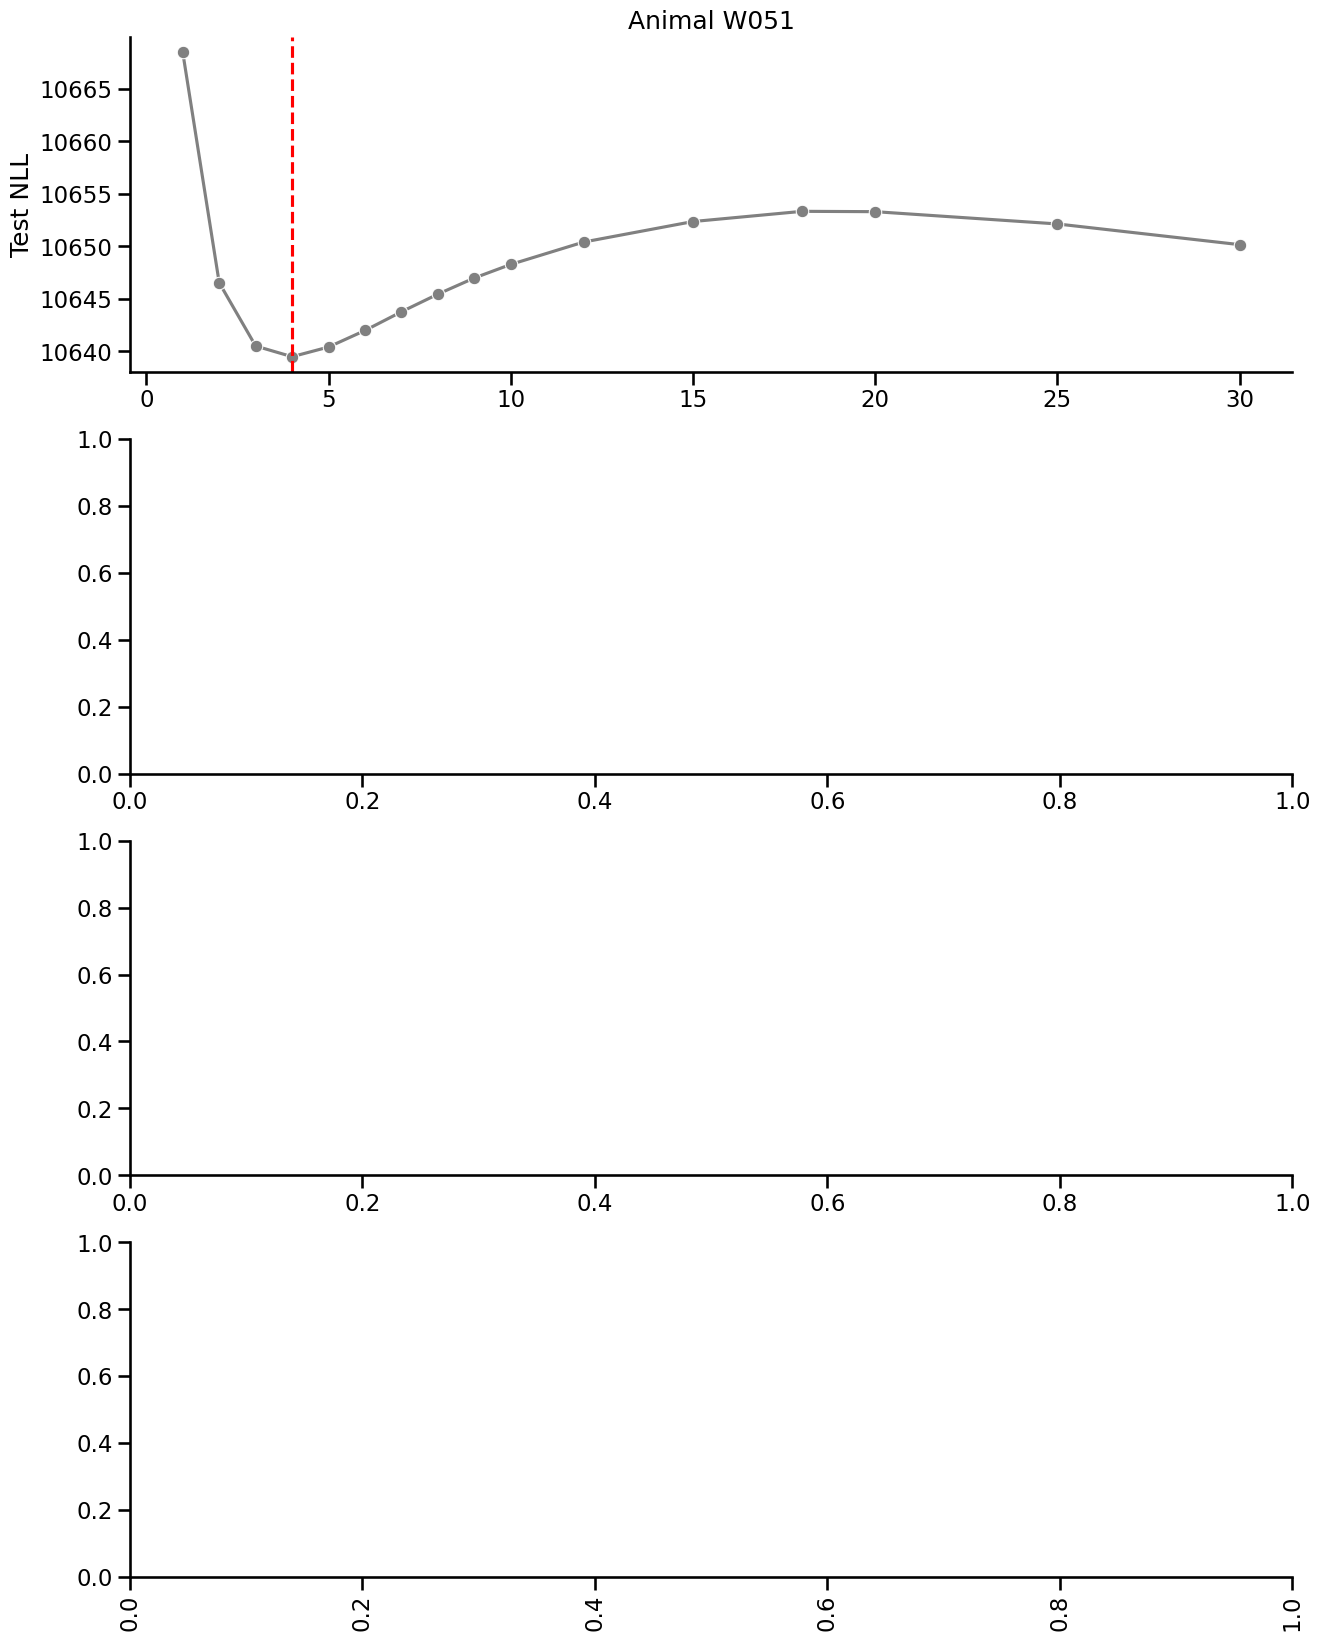

In [23]:
animals_of_interest = ["W051", "W062", "W072", "W078"]

df = mv.find_best_fit(group="prev_choice_tau")
mv.plot_nll_over_taus_by_animal(
    df=df.query("animal_id in @animals_of_interest").reset_index(drop=True),
    color="gray",
)

In [41]:
from model_visualizer import ModelVisualizerCompare

file_path = "../../data/results/"
experiment_fname = "2023_11_01_compare_prev_violation_interactions.pkl"

In [42]:
# open experiment pkls
with open(file_path + experiment_fname, "rb") as f:
    experiment = pickle.load(f)


mvc = ModelVisualizerCompare(experiment)

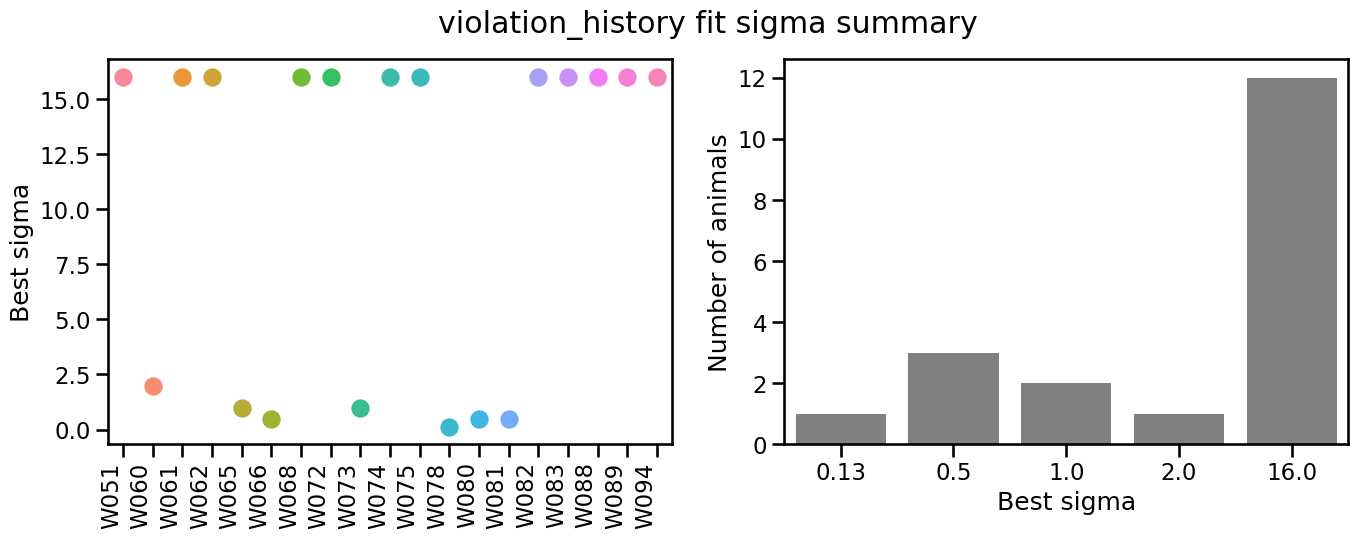

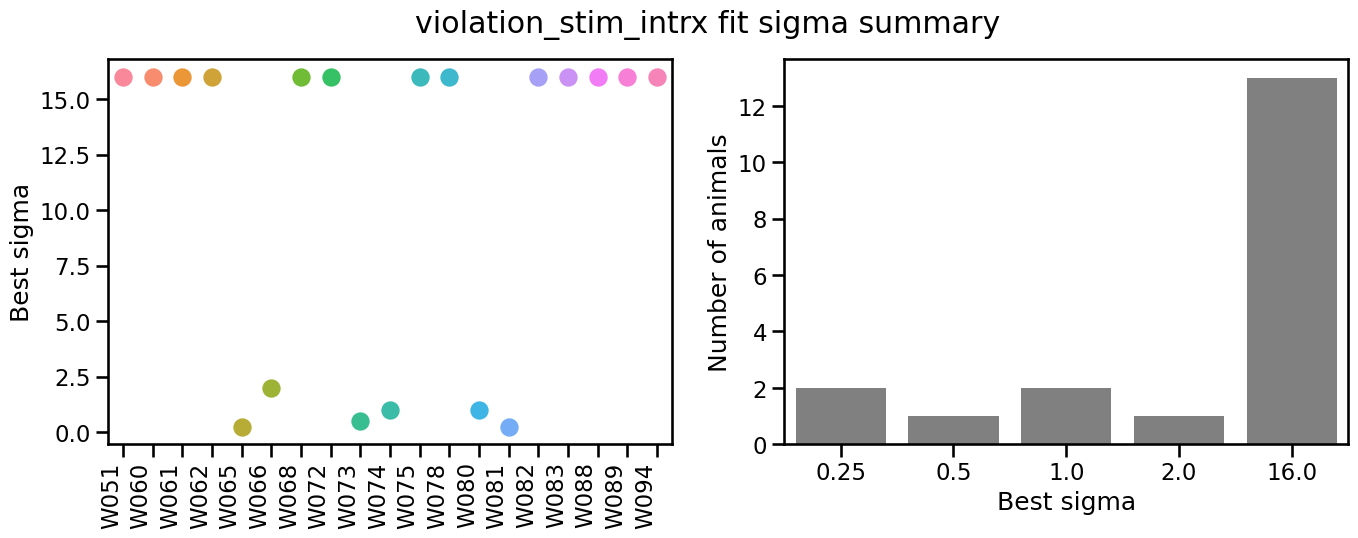

In [27]:
df = mvc.find_best_fit(group="model_name")
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

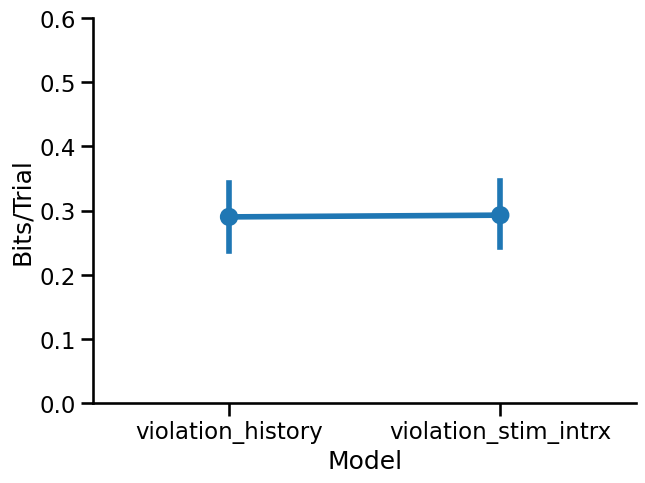

In [37]:
ylim = (0, 0.6)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mvc.plot_model_comparison(hue=None, ax=ax, ylim=ylim)

sns.despine()

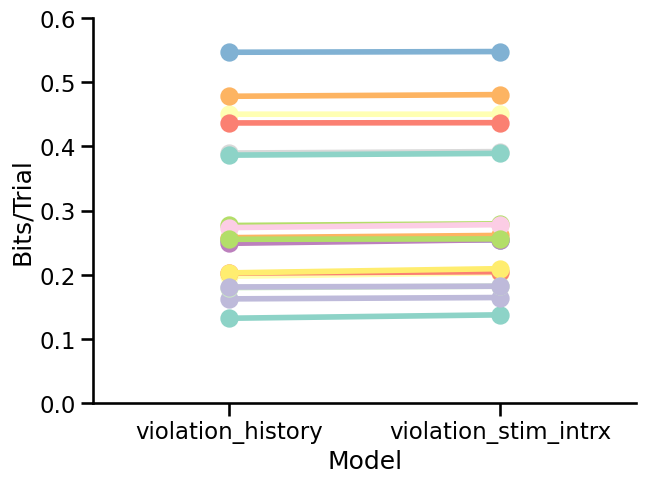

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mvc.plot_model_comparison(hue="animal_id", palette="Set3", ax=ax, ylim=ylim)
sns.despine()

## Method double check

Want to make sure the correct design matrices went into the method, it appears they did.

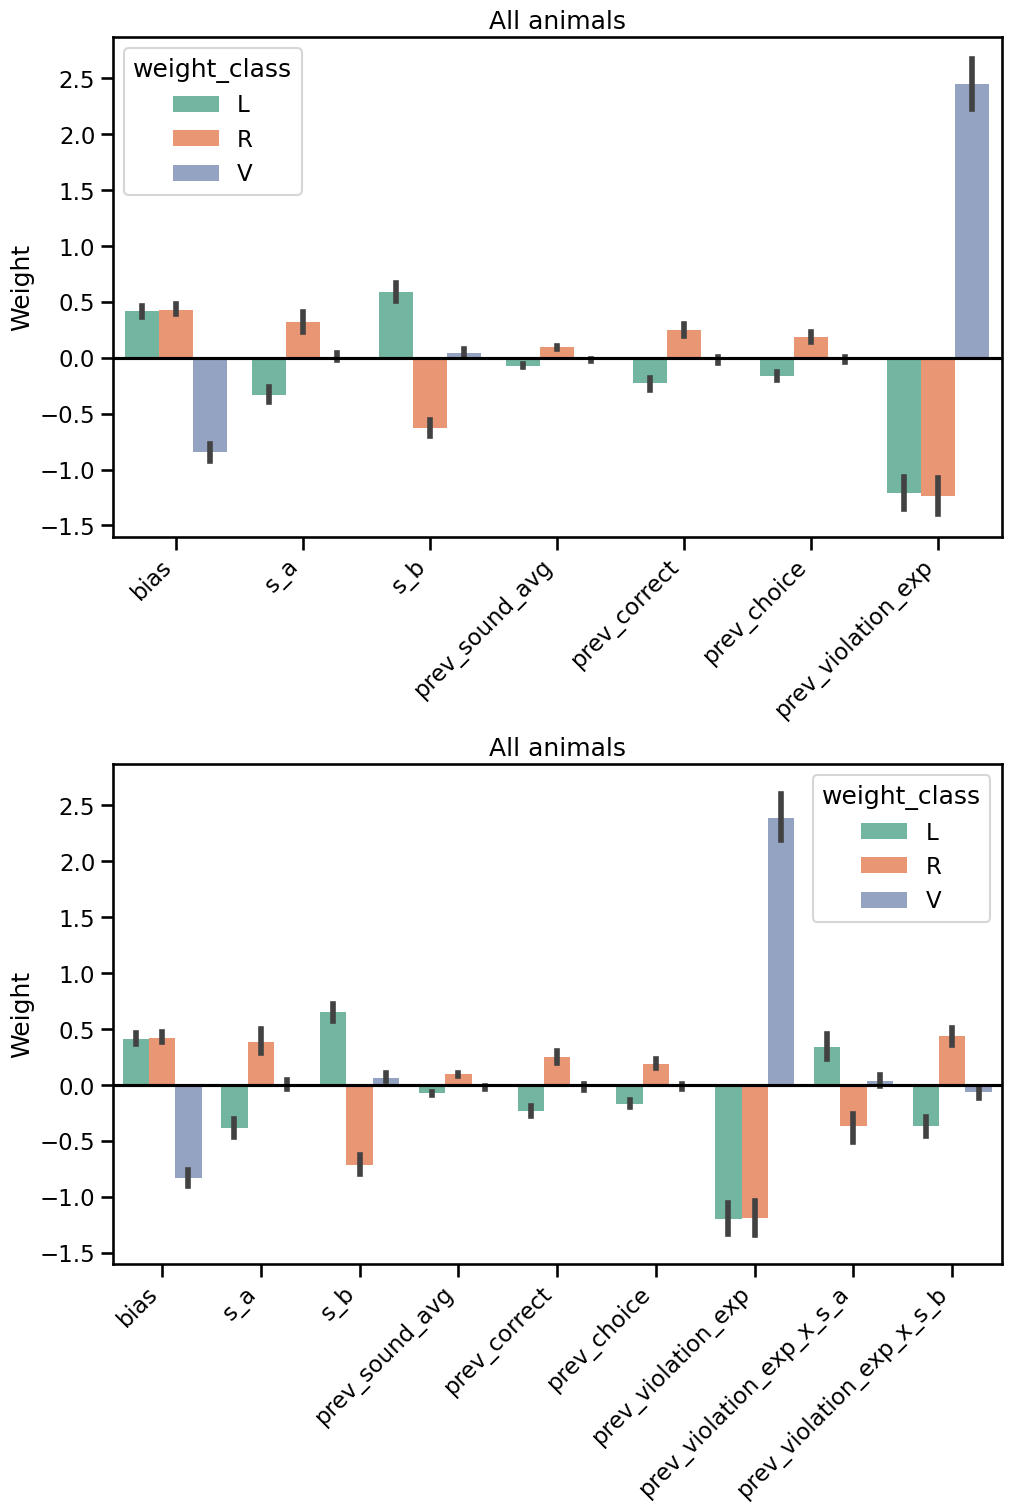

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15), constrained_layout=True, sharey=True)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
    )

Now, going to create a design matrix with violations and look at the mu, std of the column.

In [67]:
from design_matrix_generator import DesignMatrixGeneratorInteractions
from get_rat_data import get_rat_viol_data
from fitting_utils import create_violation_interaction_pairs, get_taus_df

In [68]:
animal_id = "W075"
taus_df = get_taus_df()
tau = taus_df.query("animal_id == @animal_id")["prev_violation_tau"].values[0]

In [71]:
create_violation_interaction_pairs?

Signature: create_violation_interaction_pairs(cols)
Docstring:
Quick function for creating interaction pairs for
a subset of columns in a design matrix against the filtered
previous violation history column.

params
------
cols : list of str
    columns interact with prev_violation_exp column.
    e.g. ["s_a", "s_b"]

returns
-------
interaction_pairs : list of tuples
    each tuple contains the names of two columns to interact
    when generating the design matrix
File:      ~/Desktop/github/animal-learning/src/utils/fitting_utils.py
Type:      function

In [72]:
X, Y = DesignMatrixGeneratorInteractions(model_type="multi").generate_design_matrix(
    df=get_rat_viol_data([animal_id]),
    tau=tau,
    filter_column="prev_violation",
    interaction_pairs=create_violation_interaction_pairs(["s_a", "s_b"]),
)

returning viol data for ['W075']


In [77]:
cols = [
    "s_a",
    "s_b",
    "prev_violation_exp",
    "prev_violation_exp_x_s_a",
    "prev_violation_exp_x_s_b",
]
X[cols].describe()

,s_a,s_b,prev_violation_exp,prev_violation_exp_x_s_a,prev_violation_exp_x_s_b
count,6.993700e+04,6.993700e+04,69937.000000,69937.000000,69937.000000
mean,-2.493204e-16,2.845747e-16,0.187595,-0.001588,-0.000187
std,9.028144e-01,9.028144e-01,0.165982,0.229721,0.229561
min,-1.635725e+00,-1.626912e+00,0.000000,-1.635725,-1.626912
25%,-8.197304e-01,-8.103837e-01,0.052142,-0.047911,-0.050148
50%,-3.736133e-03,6.145022e-03,0.154560,0.000000,0.000000
75%,8.122581e-01,8.226737e-01,0.279912,0.049058,0.045689
max,1.628252e+00,1.639202e+00,1.000000,1.524442,1.639202


The interactions pairs have a mean of 0 and std around 0.22. Whereas the sa,sb have mean 0 and std around 1. It doesn't seem like this would be an issue leading to larger weights but no effect.  Morveoer the max is the same and the min is smaller for the interactions (0.04 vs 0.8 for stim)

I want to do an investigation into sigma. Specifically, for each sigma, what is the test nll for each model (on a single animal basis for now)

In [80]:
mvc.compute_bits_per_trial_df()

mvc.bits_per_trial_df.head()

,animal_id,model_name,nll,sigma,tau,model_type,n_train_trials,n_test_trials,log_like,bits_per_trial
0,W051,null,11770.330612,NaN,NaN,multi,43824,11609,-11770.330612,-1.462744
1,W051,violation_history,10706.376703,16.0,6.0,multi,43824,11609,-10706.376703,0.132222
2,W051,violation_stim_intrx,10663.789104,16.0,6.0,mutli,43824,11609,-10663.789104,0.137514
3,W060,null,8283.169798,NaN,NaN,multi,35232,8157,-8283.169798,-1.465010
4,W060,violation_history,7165.729300,2.0,4.0,multi,35232,8157,-7165.729300,0.197637


In [82]:
sub_df = mvc.fit_models.query("animal_id == 'W078'").copy()

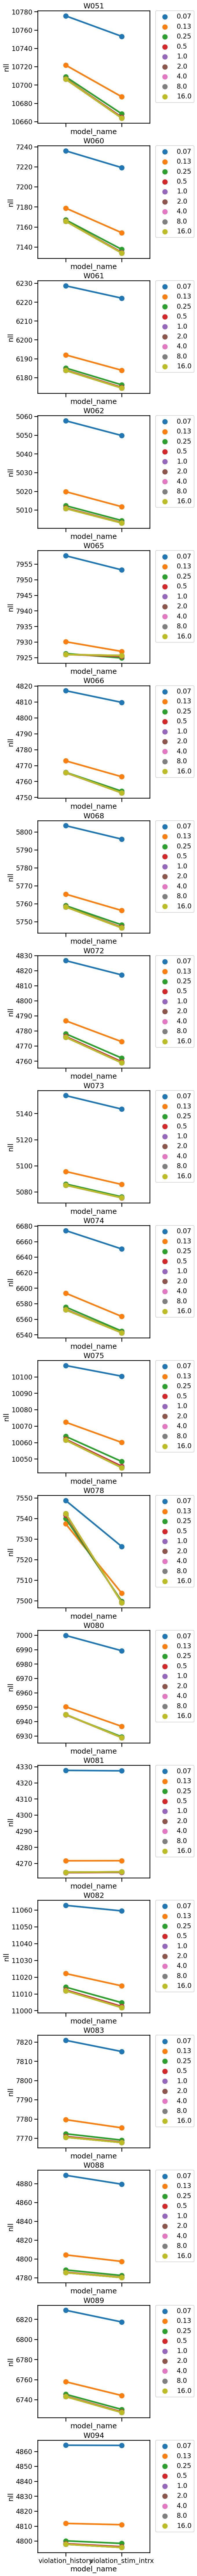

In [92]:
n_animals = mvc.experiment.n_animals

fig, ax = plt.subplots(n_animals, 1, figsize=(5, 6 * n_animals), sharex=True)

for ii, (animal_id, animal_df) in enumerate(mvc.fit_models.groupby("animal_id")):
    sns.pointplot(data=animal_df, x="model_name", y="nll", hue="sigma", ax=ax[ii])
    ax[ii].set_title(animal_id)
    # move the legned outside the plot
    ax[ii].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

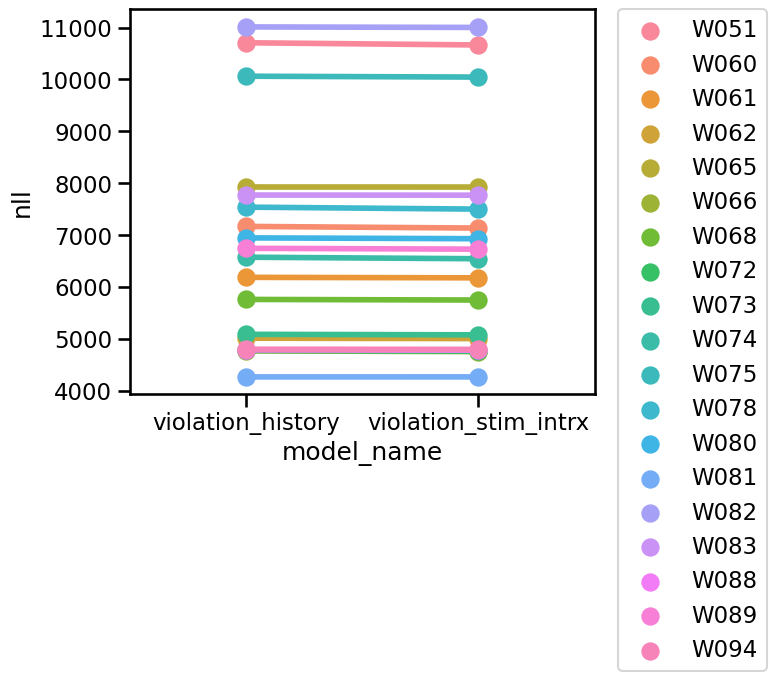

In [109]:
n_animals = mvc.experiment.n_animals

fig, ax = plt.subplots(figsize=(6, 5))
plot_df = mvc.find_best_fit(["animal_id", "model_name"])

sns.pointplot(data=plot_df, x="model_name", y="nll", hue="animal_id", ax=ax)

# move the legned outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

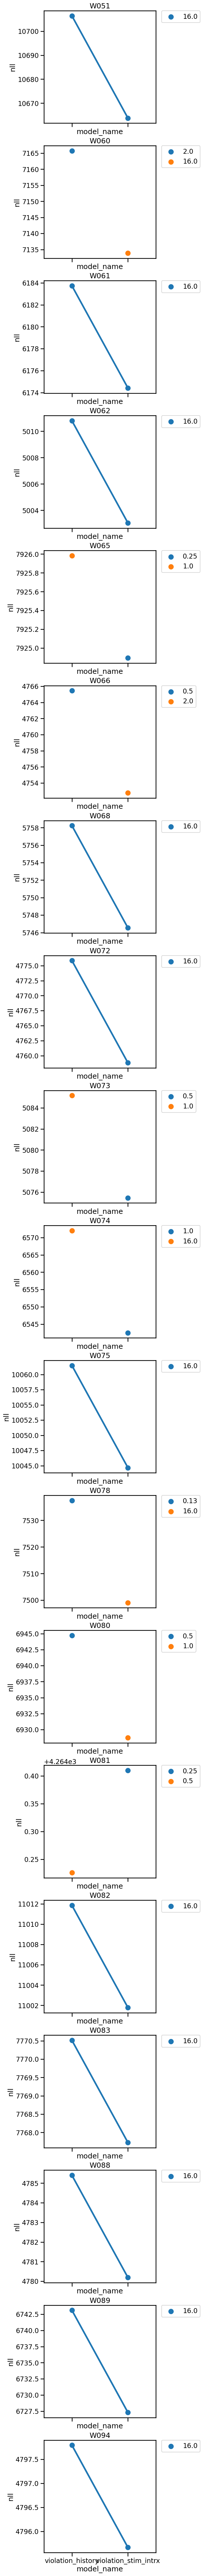

In [94]:
n_animals = mvc.experiment.n_animals

fig, ax = plt.subplots(n_animals, 1, figsize=(5, 6 * n_animals), sharex=True)

for ii, (animal_id, animal_df) in enumerate(
    mvc.find_best_fit(["animal_id", "model_name"]).groupby("animal_id")
):
    sns.pointplot(data=animal_df, x="model_name", y="nll", hue="sigma", ax=ax[ii])
    ax[ii].set_title(animal_id)
    # move the legned outside the plot
    ax[ii].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Okay so I know there is nothing going on with the sigmas- the right trend is seen, and test nll goes down in all but one case. So why is the bits per trial metric not improving?

In [107]:
best_fit = mvc.find_best_fit(["animal_id", "model_name"])
pivot_df = best_fit.pivot(index="animal_id", columns="model_name", values="nll")

pivot_df["nll_difference"] = (
    pivot_df["violation_stim_intrx"] - pivot_df["violation_history"]
)
pivot_df.nll_difference.describe()

count    19.000000
mean    -14.753163
std      12.469104
min     -42.587599
25%     -16.921098
50%     -11.702898
75%      -6.487695
max       0.183928
Name: nll_difference, dtype: float64